# Requirements

In [2]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
from numba import cuda, njit, vectorize
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import numpy as np
import random

# Simple example

In [16]:
def gaussian_pure(x, μ, σ):
    if type(x) == float:
        return math.exp(-0.5*((x - μ)/σ)**2)/(σ*math.sqrt(2.0*math.pi))
    else:
        return list(map(lambda x: math.exp(-0.5*((x - μ)/σ)**2)/(σ*math.sqrt(2.0*math.pi)), x))

In [17]:
x = np.linspace(-10.0, 10.0, 1_000_000, dtype=np.float32)
μ = np.float32(0.0)
σ = np.float32(1.0)

In [18]:
%timeit gaussian_pure(x, μ, σ)

4.63 s ± 17.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
@vectorize(['float32(float32, float32, float32)'])
def gaussian(x, μ, σ):
    return math.exp(-0.5*((x - μ)/σ)**2)/(σ*math.sqrt(2.0*math.pi))

In [20]:
%timeit gaussian(x, μ, σ)

7.21 ms ± 33.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
@vectorize(['float32(float32, float32, float32)'], target='cuda')
def gaussian_gpu(x, μ, σ):
    return math.exp(-0.5*((x - μ)/σ)**2)/(σ*math.sqrt(2.0*math.pi))

/home/gjb/miniconda3/envs/numba/lib/python3.9/site-packages/numba/cuda/decorators.py:110: NumbaDeprecationWarning: Eager compilation of device functions is deprecated (this occurs when a signature is provided)
  warn(NumbaDeprecationWarning(msg))


In [8]:
%timeit gaussian_gpu(x, μ, σ)

4.97 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
x_dev = cuda.to_device(x)
values = cuda.device_array_like(x)

In [10]:
%timeit gaussian_gpu(x, μ, σ, out=values)

2.56 ms ± 47.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
def gaussian_np(x, μ, σ):
    return np.exp(-0.5*((x - μ)/σ)**2)/(σ*np.sqrt(2.0*np.pi))

In [12]:
%timeit gaussian_np(x, μ, σ)

2.21 ms ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
pure_values = list(gaussian_pure(x, μ, σ))
values = gaussian(x, μ, σ)
gpu_values = gaussian_gpu(x, μ, σ)
np_values = gaussian_np(x, μ, σ)
np.allclose(values, gpu_values), np.allclose(values, np_values), np.allclose(values, pure_values)

(True, True, True)

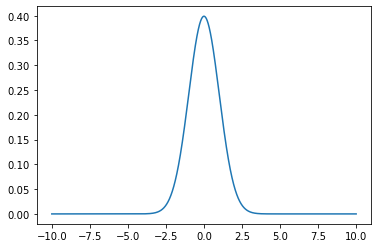

In [15]:
_ = plt.plot(x, pure_values)

# Computing $\pi$

We compute $\pi$ by throwing darts at a square and counting how many land in an inscribed circle.

## CPU implementation

In [3]:
@njit
def compute_pi_cpu(nr_tries):
    hits = 0
    for _ in range(nr_tries):
        x = random.random()
        y = random.random()
        if x**2 + y**2 < 1.0:
            hits += 1
    return 4.0*hits/nr_tries

In [5]:
compute_pi_cpu(100_000)

3.13788

## Precision

Just out of curiosity, what precision can we expect as a function of the number of darts?

In [22]:
def assess_precision(compute_pi, start_exp, stop_exp, nr_runs=5, *args):
    all_nr_tries = np.logspace(start_exp, stop_exp, num=stop_exp - start_exp + 1, dtype=np.int64)
    results = np.empty(shape=(all_nr_tries.size*nr_runs, 2))
    result_nr = 0
    for nr_tries in all_nr_tries:
        for _ in range(nr_runs):
            pi = compute_pi(nr_tries, *args)
            results[result_nr, :] = nr_tries, np.abs(pi - np.pi)/np.pi
            result_nr += 1
    return results

In [23]:
precisions = assess_precision(compute_pi_cpu, 2, 9, 5)

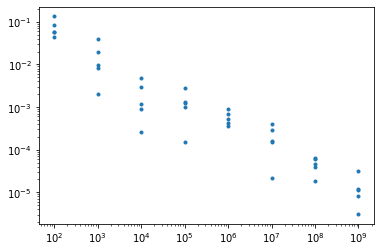

In [42]:
_ = plt.loglog(precisions[:, 0], precisions[:, 1], '.')

The precision increases, but not as fast as you might hope.

We want to compare the performance of the version that runs on CPU with the one on GPU, so we will define the number of tries in terms of number of blocks and number of threads per block, although that is not relevant for the CPU version.

In [9]:
nr_blocks = 4096
nr_threads_per_block = 128
nr_tries = 1024*nr_blocks*nr_threads_per_block

In [10]:
%timeit compute_pi_cpu(nr_tries)

3.77 s ± 45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## GPU implementation

Since this requires a random number generator, we use the numba GPU random number generator `xoroshiro128p_uniform_float32`.

In [15]:
@cuda.jit
def compute_pi_kernel(rng_states, nr_tries, result):
    idx = cuda.grid(1)
    hits = 0
    for _ in range(nr_tries):
        x = xoroshiro128p_uniform_float32(rng_states, idx)
        y = xoroshiro128p_uniform_float32(rng_states, idx)
        if x**2 + y**2 < 1.0:
            hits += 1
    result[idx] = 4.0*hits/nr_tries

It would be useful to have a wrapper function, since some scaffolding is required to use this kernel.

In [27]:
def compute_pi_gpu(nr_tries, nr_blocks, nr_threads_per_blocks):
    rng_states = create_xoroshiro128p_states(nr_blocks*nr_threads_per_block, seed=random.randint(0, 100_000))
    dev_result = cuda.device_array((nr_blocks*nr_threads_per_block, ), dtype=np.float32)
    compute_pi_kernel[nr_blocks, nr_threads_per_block](
        rng_states,
        nr_tries//(nr_blocks*nr_threads_per_block),
        dev_result
    )
    cuda.synchronize()
    return np.sum(dev_result)/dev_result.shape[0]

In [28]:
compute_pi_gpu(nr_tries, nr_blocks, nr_threads_per_block)

3.1417486667633057

In [16]:
%timeit compute_pi_gpu(nr_tries, nr_blocks, nr_threads_per_block)

114 ms ± 1.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It is clear that the GPU version is significantly faster.

In [31]:
precisions = assess_precision(compute_pi_gpu, 6, 12, 5, nr_blocks, nr_threads_per_block)

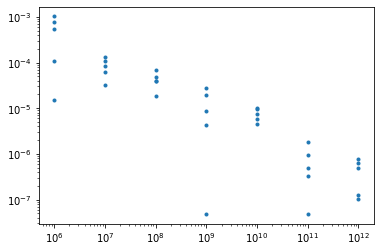

In [32]:
_ = plt.loglog(precisions[:, 0], precisions[:, 1], '.')

# Mandelbrot set

As for many of the other approeaches, we will consider the generation of the Mandelbrot set once more.

It can be easily implemented as a CUDA kernel using the numba library and specifying `cuda` as a target for the `vectorize` decorator.  We specify the signature of the function, using single precision copmlex numbers and unsigned 8-bit integers as return type.

In [15]:
@vectorize(['uint8(complex64, complex64, int32)'], target='cuda')
def mandelbrot(z, c, max_steps):
    nr_steps = 0
    while z.real**2 + z.imag**2 < 2.0 and nr_steps < max_steps:
        z = z**2 + c
        nr_steps += 1
    return nr_steps

/home/gjb/miniconda3/envs/numba/lib/python3.9/site-packages/numba/cuda/decorators.py:110: NumbaDeprecationWarning: Eager compilation of device functions is deprecated (this occurs when a signature is provided)
  warn(NumbaDeprecationWarning(msg))


Now we can generate the input complex numbers as a 2D array.

In [16]:
n = 1_000
x = np.linspace(-1.8, 1.8, n, dtype=np.float32)
y = np.linspace(-1.8, 1.8, n, dtype=np.float32)
X, Y = np.meshgrid(x, y)
z = X + 1.0j*Y

Verify that the type of `z` is as expected, i.e., single precision complex.

In [17]:
z.dtype

dtype('complex64')

Define the other input values `c` and `max_steps`.

In [18]:
c = np.complex64(0.4 + 0.6j)
max_steps = np.int32(256)

Do the computation on the device.

In [19]:
image = mandelbrot(z, c, max_steps)

The resulting data type is numpy array on the host, and its type is unsigned 8-bit as specified.

In [18]:
type(image)

numpy.ndarray

In [17]:
image.dtype

dtype('uint8')

We can visualize the result using matplotlib.

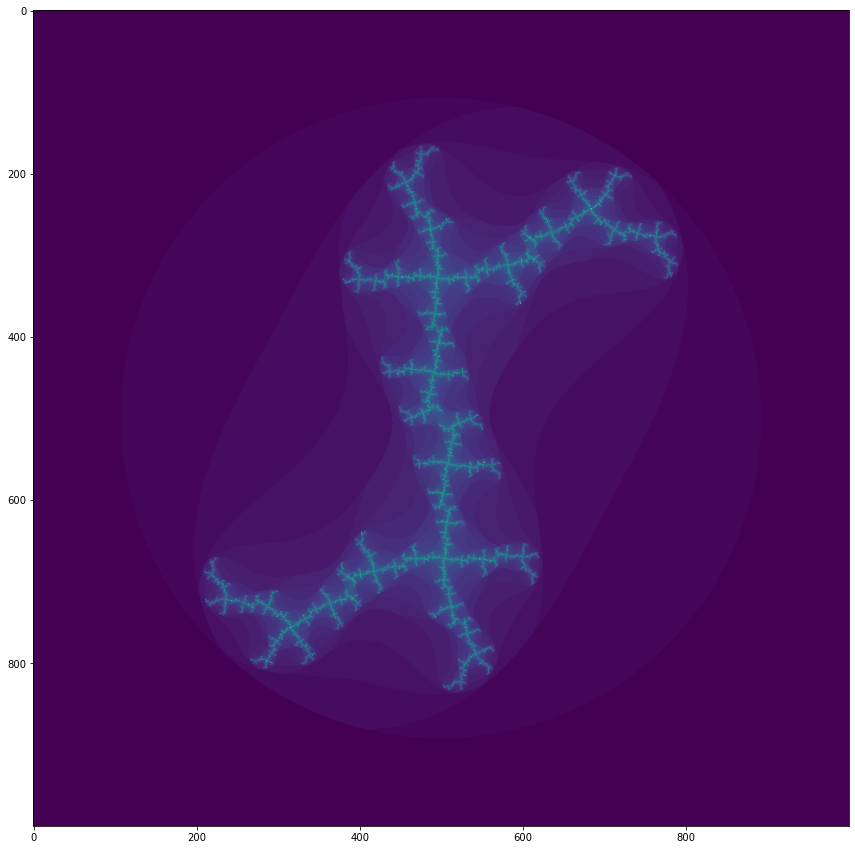

In [16]:
figure, axes = plt.subplots(figsize=(15, 15))
axes.set_aspect('equal')
_ = axes.imshow(image)

Compared to pyCUDA, using numba is considerably easier.

## Benchmarks

Let's compare the performance of numba on CPU and GPU.

In [2]:
@vectorize(['uint8(complex64, complex64, int32)'])
def mandelbrot_cpu(z, c, max_steps):
    nr_steps = 0
    while z.real**2 + z.imag**2 < 2.0 and nr_steps < max_steps:
        z = z**2 + c
        nr_steps += 1
    return nr_steps

In [10]:
@vectorize(['uint8(complex64, complex64, int32)'], target='cuda', nopython=True)
def mandelbrot_gpu(z, c, max_steps):
    nr_steps = np.uint8(0)
    while z.real*z.real + z.imag*z.imag < 2.0 and nr_steps < max_steps:
        z = z*z + c
        nr_steps += 1
    return nr_steps

/home/gjb/miniconda3/envs/numba/lib/python3.9/site-packages/numba/np/ufunc/deviceufunc.py:362: RuntimeWarning: nopython kwarg for cuda target is redundant
  warnings.warn("nopython kwarg for cuda target is redundant",
/home/gjb/miniconda3/envs/numba/lib/python3.9/site-packages/numba/cuda/decorators.py:110: NumbaDeprecationWarning: Eager compilation of device functions is deprecated (this occurs when a signature is provided)
  warn(NumbaDeprecationWarning(msg))


In [11]:
n = 10_000
x = np.linspace(-1.8, 1.8, n, dtype=np.float32)
y = np.linspace(-1.8, 1.8, n, dtype=np.float32)
X, Y = np.meshgrid(x, y)
z = X + 1.0j*Y

In [12]:
c = np.complex64(0.4 + 0.6j)
max_steps = np.int32(256)

In [13]:
%timeit mandelbrot_cpu(z, c, max_steps)

571 ms ± 6.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit mandelbrot_gpu(z, c, max_steps)

578 ms ± 9.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
z_dev = cuda.to_device(z)
image = cuda.device_array(shape=z.shape, dtype=np.uint8)

In [16]:
%timeit mandelbrot_gpu(z_dev, c, max_steps, out=image)

563 ms ± 41.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


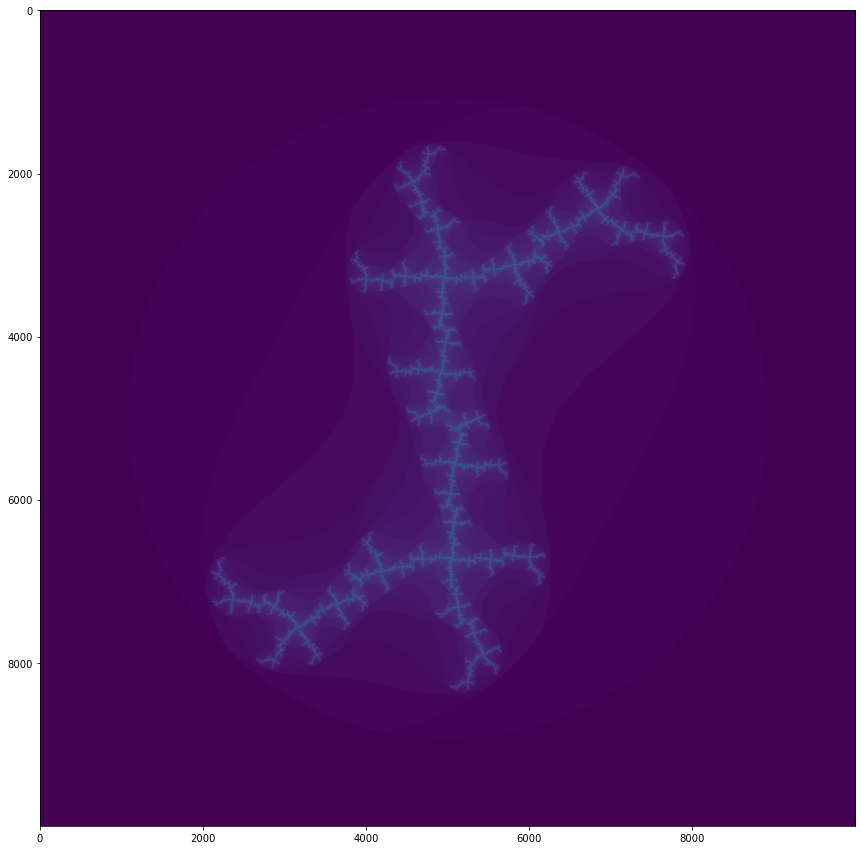

In [17]:
figure, axes = plt.subplots(figsize=(15, 15))
axes.set_aspect('equal')
_ = axes.imshow(image.copy_to_host())